
# Assignment 1 - Event-driven simulation of a two-dimensional gas
## Numerical Physics 2023
## Introduction

For this project, a Julia kernel in a Jupyter Notebook is used. The Julia kernel is a programming language that is similar to Python, but has more built in utilities for computational physics. The Jupyter Notebook is a web-based interactive computational environment for creating Jupyter notebook documents. The notebook documents contain both computer code (e.g. Julia) and rich text elements (paragraph, equations, figures, links, etc...). The notebook documents can be converted to different formats, including HTML, LaTeX, PDF, and Markdown. The Jupyter Notebook is an open-source project, and is available at https://jupyter.org/.



## Includes

In [3]:
# using Pkg
# Pkg.add("ProgressBars")
using Base.Threads,
BenchmarkTools,
DataStructures, # For PriorityQueue
Random,
Statistics,
StatsBase,
Plots,
ProgressBars

display("Number of threads: $(nthreads())")

"Number of threads: 8"

In [4]:
a = zeros(10)
Threads.@threads for i = 1:10
    a[i] = Threads.threadid()
end
a

10-element Vector{Float64}:
 1.0
 1.0
 2.0
 2.0
 3.0
 4.0
 5.0
 6.0
 7.0
 8.0

## Definitions

### Particle & collision structs

In [5]:
# Types of collisions
@enum CollisionType::Int64 uninit = 0 vwall = 1 hwall = 2 particle = 3

# Define particle struct
mutable struct Particle
    ## Particle properties
    # x, y: position
    # vx, vy: velocity
    # m: mass
    # ξ: elastic collision coefficient
    # r: radius
    # nc: realtime number of collision
    # def: true if particle is defined

    x::Float64
    y::Float64
    vx::Float64
    vy::Float64
    m::Float64
    ξ::Float64
    r::Float64
    nc::Int64

    ## Next collision properties
    coll_type::CollisionType
    other_particle_idx::Int64
    # Collision count at calculation, if coll_nc != nc when resolving collision, discard collision and calculate new
    coll_nc::Int64 

    # Time until next collision
    Δt::Float64
    

    ## Constructor
    Particle(x::Float64, y::Float64, vx::Float64, vy::Float64, m::Float64, ξ::Float64, r::Float64) =
        new(x, y, vx, vy, m, ξ, r, 0, 
        uninit::CollisionType, 0, 0, 0.0)
end

# Define function to update velocities of particles after particle collision
function update_velocities!(p_i::Particle, p_j::Particle)::Nothing
    dx = p_j.x - p_i.x
    dy = p_j.y - p_i.y
    dvx = p_j.vx - p_i.vx
    dvy = p_j.vy - p_i.vy
    dvdr = dx*dvx + dy*dvy
    ## distance between centers at collision point squared
    ## is equal to their added radii squared
    R2 = dx^2 + dy^2

    p_i.vx += (1+p_i.ξ)*(p_j.m / (p_i.m + p_j.m)) * dvdr * dx / R2
    p_i.vy += (1+p_i.ξ)*(p_j.m / (p_i.m + p_j.m)) * dvdr * dy / R2
    p_j.vx -= (1+p_j.ξ)*(p_i.m / (p_i.m + p_j.m)) * dvdr * dx / R2
    p_j.vy -= (1+p_j.ξ)*(p_i.m / (p_i.m + p_j.m)) * dvdr * dy / R2

    return nothing
end

# Define function to update velocity of a particle
# after collision with a vertical wall
function update_velocity_vertical_wall!(p::Particle)::Nothing
    p.vx *= -p.ξ
    p.vy *= p.ξ
    return nothing
end

# Define function to update velocity of a particle
# after collision with a horizontal wall
function update_velocity_horizontal_wall!(p::Particle)::Nothing
    p.vx *= p.ξ
    p.vy *= -p.ξ
    
    return nothing
end

# Define function to update positions of particles
function update_positions!(particles::Vector{Particle}, Δt::Float64)::Nothing
    for p in particles
        p.x += p.vx * Δt
        p.y += p.vy * Δt
    end
    return nothing
end

update_positions! (generic function with 1 method)

### Time calculations

In [6]:
# Define function to calculate time until collision with vertical wall
function time_until_collision_vertical_wall(p::Particle, L::Float64)::Float64
    if p.vx > 0 ## Right wall
        return (L - p.r - p.x) / p.vx

    elseif p.vx < 0 ## Left wall
        return (p.r - p.x) / p.vx

    else ## It is standing still in x, probably? :^)
        return Inf
    end
end

# Define function to calculate time until collision with horizontal wall
function time_until_collision_horizontal_wall(p::Particle, L::Float64)::Float64
    if p.vy > 0 ## Top wall
        return (L - p.r - p.y) / p.vy

    elseif p.vy < 0 ## Bottom wall
        return (p.r - p.y) / p.vy

    else ## It is standing still in y, plausibly? 8-)
        return Inf
    end
end

# Define function to calculate time until collision between two particles
function time_until_collision(p1::Particle, p2::Particle)::Float64
    dx = p2.x - p1.x
    dy = p2.y - p1.y
    dvx = p2.vx - p1.vx
    dvy = p2.vy - p1.vy

    dvdr = dx*dvx + dy*dvy
    dvdv = dvx^2 + dvy^2
    drdr = dx^2 + dy^2
    R2 = (p1.r + p2.r)^2

    # Discriminant in collision
    d = dvdr^2 - dvdv * (drdr - R2)

    if d <= 0 || dvdr >= 0
        return Inf
    else
        return -(dvdr + sqrt(d)) / dvdv
    end
end

time_until_collision (generic function with 1 method)

### Simulation loop function

In [7]:
# Calculate time until next collision for each particle
function calc_collision!(i, particles::Vector{Particle})::Nothing
    p_i = particles[i]
    p_i.Δt = Inf
    p_i.coll_type = uninit::CollisionType
    p_i.other_particle_idx = 0
    
    @inbounds @threads for j in filter(x -> x != i, eachindex(particles))
        p_j = particles[j]
        Δt = time_until_collision(p_i, p_j)
        if Δt < p_i.Δt
            p_i.Δt = Δt
            p_i.coll_type = particle::CollisionType
            p_i.other_particle_idx = j
        end
    end

    return nothing
end

# Define function to calculate time until next wall collision
function calc_wall_collision!(i, particles::Vector{Particle}, L::Float64)::Nothing
    p_i = particles[i]
    
    Δt = time_until_collision_vertical_wall(p_i, L)
    if Δt < p_i.Δt
        p_i.Δt = Δt
        p_i.coll_type = vwall::CollisionType
        p_i.other_particle_idx = 0
    end

    Δt = time_until_collision_horizontal_wall(p_i, L)
    if Δt < p_i.Δt
        p_i.Δt = Δt
        p_i.coll_type = hwall::CollisionType
        p_i.other_particle_idx = 0
    end
    
    return nothing
end

function update!(particles::Vector{Particle}, pq::PriorityQueue{Int64, Float64})::Nothing
    i, Δt = peek(pq)
    p_i = particles[i]
    j = p_i.other_particle_idx

    # Update positions of all particles
    update_positions!(particles, Δt)

    # Update priority queue with new times
    for k in eachindex(particles)
        particles[k].Δt -= Δt
        pq[k] = particles[k].Δt
        @assert particles[k].Δt >= 0.0
    end

    ## Handle the collision and velocity update
    if p_i.coll_nc == p_i.nc
        if p_i.coll_type == vwall::CollisionType
            update_velocity_vertical_wall!(p_i)
            p_i.nc += 1
            
        elseif p_i.coll_type == hwall::CollisionType
            update_velocity_horizontal_wall!(p_i)
            p_i.nc += 1

        elseif p_i.coll_type == particle::CollisionType

            p_j = particles[j]

            if p_j.coll_nc == p_j.nc
                # Discard if the other particle has collided with something before this
                ## Complete the collision for both particles
                update_velocities!(p_i, p_j)
                p_j.nc += 1
                p_i.nc += 1
            end

            # Calc collision for the other particle
            calc_collision!(j, particles)
            calc_wall_collision!(j, particles, L)
            p_j.coll_nc = deepcopy(p_j.nc) # collision count at the time. If mismatch when resolving collision, it is ignored
            # Add the other particle to the priority queue
            pq[j] = p_j.Δt

        end
        
    end

    # Calculate time until next collision for this particle
    calc_collision!(i, particles)
    calc_wall_collision!(i, particles, L)
    p_i.coll_nc = deepcopy(p_i.nc) ## collision count at the time. If mismatch when resolving collision, it is ignored
    pq[i] = p_i.Δt

    return nothing
end

# Define simulation loop
function simulate!(particles::Vector{Particle}, L::Float64, N::Int64)::Nothing
    # Initialize priority queue with particle indexes and time until collision
    pq = PriorityQueue{Int64, Float64}()

    # Calculate time until next collision for each particle
    for i in 1:length(particles)
        calc_collision!(i, particles)
        calc_wall_collision!(i, particles, L)
        pq[i] = particles[i].Δt
    end

    # Run simulation
    for i in 1:N
        # Get particle with next collision
        update!(particles, pq)
    end
    return nothing
end 


simulate! (generic function with 1 method)

In [8]:
# Define function to plot particles
function plot_particles(particles::Vector{Particle}, L::Float64, color::String, label::String)
    # Plot particles
    scatter([particles[i].x for i in 1:length(particles)],
        [particles[i].y for i in 1:length(particles)],
        color = color, label = label)

    # Plot vertical walls
    plot!([0, 0], [0, L], color = "black", label = nothing)
    plot!([L, L], [0, L], color = "black", label = nothing)

    # Plot horizontal walls
    plot!([0, L], [0, 0], color = "black", label = nothing)
    plot!([0, L], [L, L], color = "black", label = nothing)
end

function plot_particles!(particles::Vector{Particle}, L::Float64, color::String, label::String)
    # Plot particles
    scatter!([particles[i].x for i in 1:length(particles)],
        [particles[i].y for i in 1:length(particles)],
        color = color, label = label)

end

function plot_line!(p0, p1)
    plot!([p0.x, p1.x], [p0.y, p1.y], color = "black", label = nothing)
end

plot_line! (generic function with 1 method)

In [9]:
function energy(particles)
    return sum([0.5 * p.m * (p.vx^2 + p.vy^2) for p in particles])
end

energy (generic function with 1 method)

### Problem 4

0.006938614435555442

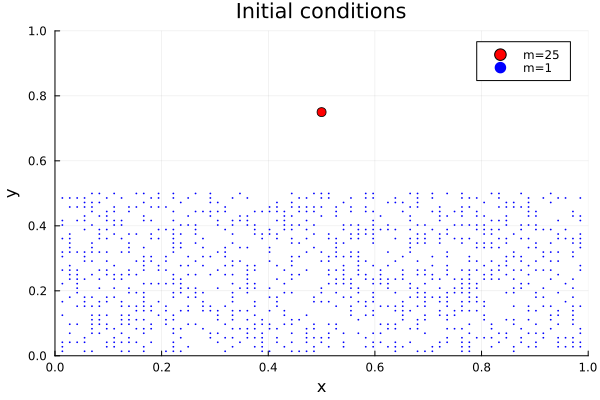

In [10]:
# Particle
# x, y: position
# vx, vy: velocity
# m: mass
# ξ: elastic collision coefficient
# r: radius
# nc: number of collisions

# Define initial conditions
L = 1.0
ξ = 1.0
m = 1.0
M = 25 * m
N = 1000
# Suggested packing fraction is approximately 0.5+~
# Radius should then be
# Area of half the box A_b = 0.5*L^2
# Area of a particle A_p = π*r^2
# Packing fraction = A_p/A_b = N*π*r^2/(0.5*L^2) = π*r^2/(0.5*L^2)
# =>    r = sqrt(0.5*L^2/π) * 0.60
r = sqrt(0.5*L^2/(N*π)) * 0.55
R = 5*r
display(r)

grid_sampler = [(x,y) for x in 2r:2r:1.0-2r, y in 2r:2r:0.5]

xys = sample(grid_sampler, (N), replace = false)
v0 = 0.1

# Half of particles use m0, other half use m1
particles = [Particle(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0) for i in 1:N+1]
particles[1] = Particle(0.5, 0.75, 0.0, -v0, M, ξ, R)
particles[2:end] = [Particle(xys[i][1], xys[i][2], 0.0, 0.0, m, ξ, r) for i in 1:N]
p0 = deepcopy(particles)

scatter([particles[1].x], [particles[1].y], markersize=5, color="red", label="m=25",
ylims=(0,1), xlims=(0,1), title="Initial conditions", xlabel="x", ylabel="y")
scatter!([xys[i][1] for i in 1:N], [xys[i][2] for i in 1:N], markersize=1, color="blue", label="m=1",
markerstrokewidth=0)


In [11]:
# Run simulation
Nt = 1000
p_log = [particles for i in 1:Nt+1]
p_log[1] = deepcopy(particles)

for i in 1:Nt
    simulate!(particles, L, 1)
    p_log[i+1] = deepcopy(particles)
end

┌ Info: Saved animation to 
│   fn = /home/haralg/Projects/TFY4235_NumFys/tmp.gif
└ @ Plots /home/haralg/.julia/packages/Plots/3E7jF/src/animation.jl:114


Plots.AnimatedGif("/home/haralg/Projects/TFY4235_NumFys/tmp.gif")
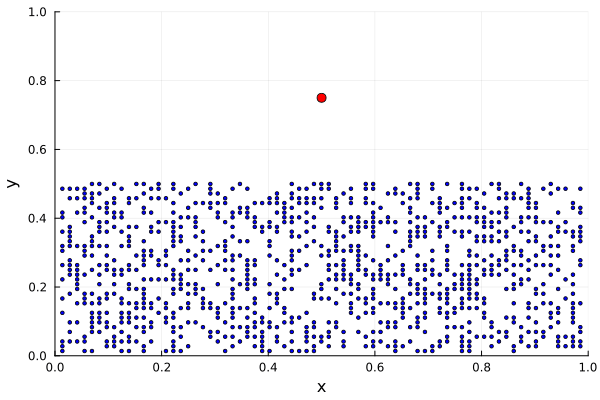

In [13]:
@gif for particles in p_log[1:10:end]
    scatter([particles[1].x], [particles[1].y], markersize=5, color="red", legend=nothing,
    ylims=(0,1), xlims=(0,1), xlabel="x", ylabel="y")
    scatter!([particles[i].x for i in 2:N+1], [particles[i].y for i in 2:N+1], markersize=2, color="blue", label=nothing)
end

In [ ]:
display(particles[1])
scatter([particles[i].x for i in 2:N+1],[particles[i].y for i in 2:N+1], markersize=1, color="blue", label="m=1",)
scatter!([particles[1].x], [particles[1].y], markersize=5, color="red", label="m=25",
ylims=(0,1), xlims=(0,1), title="Initial conditions", xlabel="x", ylabel="y")

In [ ]:
# Run simulation
Nt = 1
simulate!(particles, L, Nt)

In [ ]:
display(particles[1])
scatter([particles[i].x for i in 2:N+1],[particles[i].y for i in 2:N+1], markersize=1, color="blue", label="m=1",)
scatter!([particles[1].x], [particles[1].y], markersize=5, color="red", label="m=25",
ylims=(0,1), xlims=(0,1), title="Initial conditions", xlabel="x", ylabel="y")

In [ ]:
# Run simulation
Nt = 10
simulate!(particles, L, Nt)

In [ ]:
display(particles[1])
scatter([particles[i].x for i in 2:N+1],[particles[i].y for i in 2:N+1], markersize=1, color="blue", label="m=1",)
scatter!([particles[1].x], [particles[1].y], markersize=5, color="red", label="m=25",
ylims=(0,1), xlims=(0,1), title="Initial conditions", xlabel="x", ylabel="y")